In [ ]:
# This code sets up the environment to download data from Kaggle

# Install the Kaggle library
!pip install kaggle

# Import the files module from google.colab
from google.colab import files

# Prompt the user to upload the kaggle.json file
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Create a directory for Kaggle and move the json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully! 👍")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API configured successfully! 👍


In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded file into a folder named 'plantdisease'
# The '-q' flag is for 'quiet' mode to avoid listing all the files
!unzip -q plantdisease.zip -d ./plantdisease

print("\nDataset downloaded and unzipped! ✅")

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 645M/658M [00:02<00:00, 222MB/s]
100% 658M/658M [00:02<00:00, 326MB/s]

Dataset downloaded and unzipped! ✅


In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the main data directory
data_dir = './plantdisease/plantvillage/PlantVillage'

# List all the available classes (disease types)
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

print(f"Found {num_classes} classes:")
print(class_names)

Found 15 classes:
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# Define image size and batch size
IMAGE_SIZE = 256
BATCH_SIZE = 32

# Create the full datasets first
full_train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

full_validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# --- NEW: Create smaller datasets for faster training ---
# We'll take about 4000 images for training and 1000 for validation

# Number of batches to take for a smaller training set (~4000 images)
train_batches_to_take = 125
# Number of batches to take for a smaller validation set (~1000 images)
val_batches_to_take = 32

# Use the .take() method to create the smaller datasets
train_dataset = full_train_dataset.take(train_batches_to_take)
validation_dataset = full_validation_dataset.take(val_batches_to_take)

print("\n✅ Created smaller datasets for faster experiments!")
print(f"Using approximately {train_batches_to_take * BATCH_SIZE} images for training.")
print(f"Using approximately {val_batches_to_take * BATCH_SIZE} images for validation.")

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.

✅ Created smaller datasets for faster experiments!
Using approximately 4000 images for training.
Using approximately 1024 images for validation.


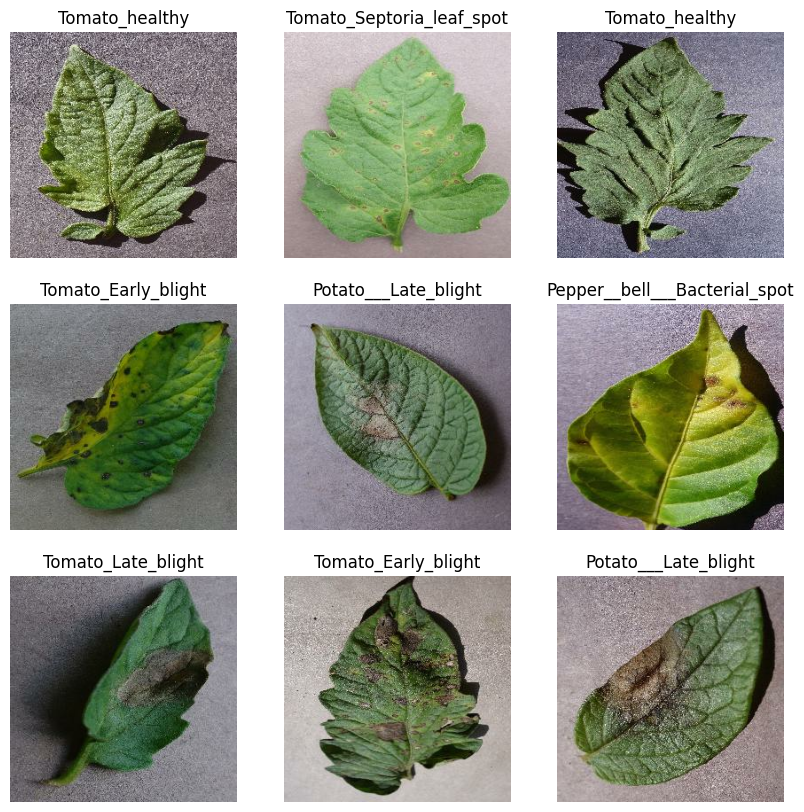

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# --- 1. Define Data Augmentation ---
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
  ]
)

# --- 2. Build the Model ---

# Define the input shape
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Get the pre-trained MobileNetV2 model, without its top classification layer
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model so we don't change its learned weights
base_model.trainable = False

# Create our new model on top
model = Sequential([
  data_augmentation,          # Apply random augmentation
  base_model,                 # The expert base model
  layers.GlobalAveragePooling2D(), # Pool the features
  layers.Dense(num_classes)   # Our final prediction layer
])


# --- 3. Compile the Model ---
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Let's see the architecture of our model
model.summary()

/tmp/ipython-input-2978230887.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Set the number of epochs
EPOCHS = 10

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)
print("\nModel training complete! 🎉")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.2516 - loss: 2.3608 - val_accuracy: 0.4268 - val_loss: 1.7604
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.4913 - loss: 1.6122 - val_accuracy: 0.4805 - val_loss: 1.5776
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5647 - loss: 1.4013 - val_accuracy: 0.5195 - val_loss: 1.4586
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.6065 - loss: 1.2769 - val_accuracy: 0.5332 - val_loss: 1.4701
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.6265 - loss: 1.2044 - val_accuracy: 0.5508 - val_loss: 1.3829
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.6261 - loss: 1.1498 - val_accuracy: 0.5693 - val_loss: 1.2848
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.6623 - loss: 1.0817 - val_accuracy: 0.5479 - val_loss: 1.3795
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.6689 - loss: 1.0443 - val_accu

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all the layers before the 100th layer
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Re-compile the model with a very low learning rate
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# See the updated summary with more trainable parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 1,880,655 (7.17 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# Set the number of fine-tuning epochs
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

# Continue training the model, picking up where we left off
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
print("\nModel fine-tuning complete! 🏆")

Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - accuracy: 0.1469 - loss: 8.2231 - val_accuracy: 0.2754 - val_loss: 3.7054
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - accuracy: 0.4056 - loss: 1.9854 - val_accuracy: 0.3438 - val_loss: 2.7955
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.4919 - loss: 1.5466 - val_accuracy: 0.4160 - val_loss: 2.2866
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.5488 - loss: 1.3613 - val_accuracy: 0.4463 - val_loss: 2.0305
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.5824 - loss: 1.2693 - val_accuracy: 0.4727 - val_loss: 1.7982
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.6056 - loss: 1.1851 - val_accuracy: 0.5176 - val_loss: 1.5839
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.6251 - loss: 1.0936 - val_accuracy: 0.5273 - val_loss: 1.5307
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.6499 - loss: 1.0558 - 

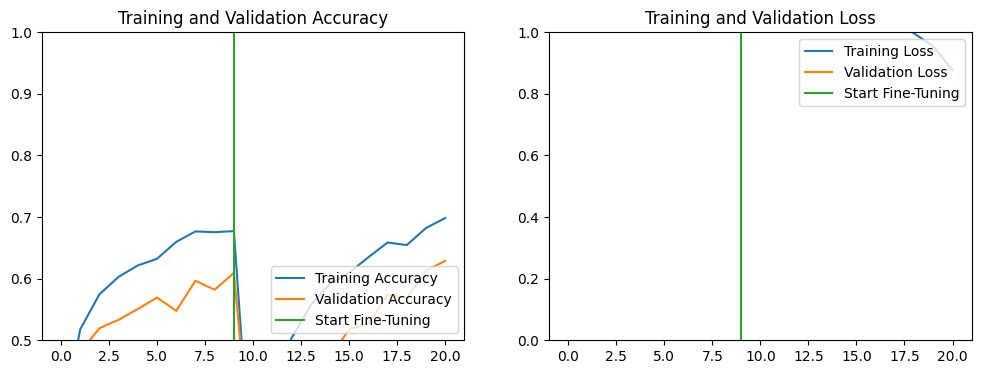

In [ ]:
# Append the fine-tuning history to the original history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot the combined history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the model to a file
model.save("GreenGuardian_model.h5")

print("Model saved successfully! 💾")

Model saved successfully! 💾


In [ ]:
# We need the class names from our training dataset
class_names = full_train_dataset.class_names

# Create a dictionary to map disease names to cure recommendations
# (These are examples and should be replaced with expert advice)
cure_recommendations = {
    'Potato___Early_blight': 'Apply a fungicide containing chlorothalonil or mancozeb. Ensure proper spacing for air circulation.',
    'Potato___Late_blight': 'This is a serious disease. Use fungicides like metalaxyl or chlorothalonil. Remove and destroy infected plants.',
    'Potato___healthy': 'Your plant is healthy! Maintain good watering and fertilization practices.',
    'Tomato___Bacterial_spot': 'Use copper-based fungicides. Avoid overhead watering. Prune affected leaves.',
    'Tomato___Leaf_Mold': 'Ensure good ventilation. Apply fungicides containing mancozeb or chlorothalonil.',
    'Tomato___Septoria_leaf_spot': 'Remove infected leaves. Use fungicides containing chlorothalonil. Mulch around the base of plants.',
    'Tomato___healthy': 'Your plant is healthy! Keep up the good work.'
    # Add more recommendations for all other classes here...
}

# A default message for diseases not in our dictionary
default_cure = "Consult a local agricultural expert for cure recommendations."

print("Cure recommendation dictionary created. 💡")

Cure recommendation dictionary created. 💡


In [ ]:
import numpy as np

def predict_and_recommend(model, img_path):
  """
  This function takes a model and an image path, and returns the prediction and recommendation.
  """
  # Load and preprocess the image
  img = tf.keras.utils.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # Make a prediction
  predictions = model.predict(img_array)
  predicted_class_index = np.argmax(predictions[0])
  predicted_class_name = class_names[predicted_class_index]

  # Get the cure recommendation
  cure = cure_recommendations.get(predicted_class_name, default_cure)

  # Display the results
  plt.imshow(img)
  plt.title(f"Prediction: {predicted_class_name}")
  plt.axis("off")
  plt.show()

  print(f"\nDisease Detected: {predicted_class_name}")
  print(f"Cure Recommendation: {cure}")

print("Prediction function is ready. 🤖")

Prediction function is ready. 🤖


Loading saved model...


Model loaded successfully.

Please upload a leaf image for diagnosis...


Saving f94c3f16-e435-4417-9a86-e0bad499a957.jpeg to f94c3f16-e435-4417-9a86-e0bad499a957.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


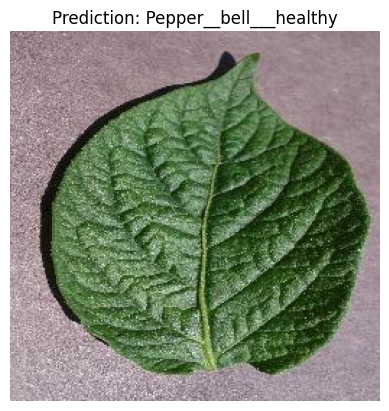


Disease Detected: Pepper__bell___healthy
Cure Recommendation: Consult a local agricultural expert for cure recommendations.


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files

# Load the saved model
print("Loading saved model...")
loaded_model = load_model('GreenGuardian_model.h5')
print("Model loaded successfully.")

# Upload an image file
print("\nPlease upload a leaf image for diagnosis...")
uploaded = files.upload()

# Get the path of the uploaded file
for file_path in uploaded.keys():
  # Make a prediction and recommend a cure
  predict_and_recommend(loaded_model, file_path)

In [ ]:
# Install the Google AI Python SDK
!pip install -q -U google-generativeai

import google.generativeai as genai
from google.colab import userdata

# Configure the API key
try:
    api_key = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=api_key)
    print("Gemini API configured successfully! 🤖")
except Exception as e:
    print(f"Error configuring API key: {e}\nPlease make sure you have set the GEMINI_API_KEY secret correctly.")

Gemini API configured successfully! 🤖


In [26]:
# Create an instance of the Gemini Pro model
model_genai = genai.GenerativeModel('gemini-1-5-flash')

def get_ai_recommendation(disease_name):
  """
  Generates a cure recommendation using the Gemini AI model.
  """
  # We don't need recommendations for healthy plants
  if "healthy" in disease_name.lower():
    return "The plant is healthy! No treatment is necessary. Just continue with good care practices."

  # Create a prompt for the AI
  prompt = f"""
  You are GreenGuardian, an expert AI assistant for plant health.
  A plant has been diagnosed with: "{disease_name}".

  Please provide a helpful, easy-to-understand guide for a home gardener on how to treat this disease. Structure your response with the following sections:
  1.  **Disease Overview:** A brief description of what this disease is.
  2.  **Immediate Actions:** The first steps the gardener should take right now.
  3.  **Treatment Options:** Suggest both organic and chemical treatments if applicable.
  4.  **Prevention Tips:** How to avoid this disease in the future.

  Keep the tone encouraging and clear.
  """

  # Generate the content
  try:
    response = model_genai.generate_content(prompt)
    return response.text
  except Exception as e:
    return f"Error generating recommendation: {e}"

print("AI Recommendation function is ready. 🧠")

AI Recommendation function is ready. 🧠



Please upload a leaf image to begin the full AI diagnosis...


Saving pepper bell BS.jpeg to pepper bell BS (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Disease Detected: Potato___Late_blight

Asking GreenGuardian AI for a recommendation...


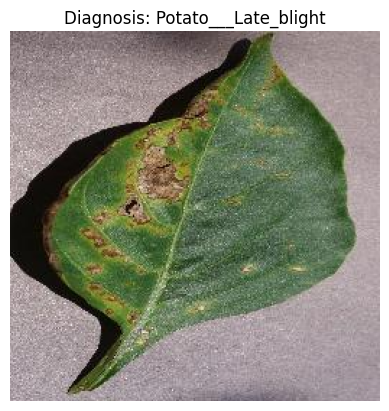

--- GreenGuardian AI Recommendation ---
Error generating recommendation: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1-5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-1-5-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


In [27]:
# This is the final function that combines both AIs
def run_full_ai_diagnosis(model_cnn, img_path):
  """
  Takes a CNN model and an image path.
  1. Predicts the disease using the CNN.
  2. Generates a cure using the Generative AI.
  """
  # --- Part 1: Disease Detection (CNN) ---
  img = tf.keras.utils.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model_cnn.predict(img_array)
  predicted_class_index = np.argmax(predictions[0])
  predicted_class_name = full_train_dataset.class_names[predicted_class_index] # Using the full dataset class names

  # --- Part 2: Cure Recommendation (Generative AI) ---
  print(f"Disease Detected: {predicted_class_name}")
  print("\nAsking GreenGuardian AI for a recommendation...")
  recommendation = get_ai_recommendation(predicted_class_name)

  # --- Part 3: Display Results ---
  plt.imshow(img)
  plt.title(f"Diagnosis: {predicted_class_name}")
  plt.axis("off")
  plt.show()

  print("--- GreenGuardian AI Recommendation ---")
  print(recommendation)


# --- Let's Test It! ---
# Load your trained image classifier model
from tensorflow.keras.models import load_model
loaded_model_cnn = load_model('GreenGuardian_model.h5')

# Upload an image
from google.colab import files
print("\nPlease upload a leaf image to begin the full AI diagnosis...")
uploaded = files.upload()

# Run the full diagnosis
for file_path in uploaded.keys():
  run_full_ai_diagnosis(loaded_model_cnn, file_path)